In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import dltools

batch_size, num_steps = 32, 35
train_iter, vocab = dltools.load_data_time_machine(batch_size, num_steps)

In [2]:
# 构造一个具有256个隐藏单元的单隐藏层的循环神经网络层 rnn_layer。
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [3]:
# 初始化隐藏状态
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [4]:
# 需要强调的是，rnn_layer的“输出”（Y）不涉及输出层的计算
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [5]:
# 为一个完整的循环神经网络模型定义了一个RNNModel类
class RNNModel(nn.Module):
    """循环神经网络模型。"""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # 如果RNN是双向的（之后将介绍），`num_directions`应该是2，否则应该是1。
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # 全连接层首先将`Y`的形状改为(`时间步数`*`批量大小`, `隐藏单元数`)。
        # 它的输出形状是 (`时间步数`*`批量大小`, `词表大小`)。
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state
    
    # 初始化隐藏状态
    def begin_state(self, device, batch_size=1):
        return  torch.zeros((self.num_directions * self.rnn.num_layers,
                             batch_size, self.num_hiddens),
                            device=device)


In [6]:
# 在训练模型之前，让我们基于一个具有随机权重的模型进行预测。
device = dltools.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
dltools.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerxkkkkkkkkk'

perplexity 1.3, 34863.3 tokens/sec on cpu
time traveller after the pause the thing to thethint you cabnot 
travelleryou can s of br cone thent in but you and the isth


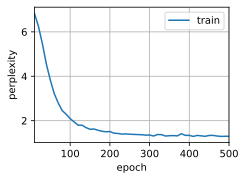

In [8]:
# 模型训练阶段
num_epochs, lr = 500, 1
dltools.train_ch8(net, train_iter, vocab, lr, num_epochs, device)